In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
RISK_FREE_RATE = 0.068
EQUITY_RISK_PREMIUM = 0.055
R2_THRESHOLD = 0.3  # Only include regressions with R^2 > 0.3
FILE_PATH = "TRP_TVBET_Analysis_Final.xlsx"
EXCLUDED_SHEETS = ["Monthly_1Y", "Monthly_2Y"]

In [3]:
try:
    xls = pd.ExcelFile(FILE_PATH)
except FileNotFoundError:
    print(f"Error: Could not find '{FILE_PATH}'. Run the previous download script first.")
    exit()

results_list = []
plot_data = {}

In [4]:
print(f"Filtering regressions with R-Squared > {R2_THRESHOLD}...")
print(f"{'TIMEFRAME':<15} | {'BETA':<10} | {'ALPHA':<10} | {'R-SQUARED':<10}")
print("-" * 60)

for sheet_name in xls.sheet_names:
    if sheet_name in EXCLUDED_SHEETS:
        continue
    try:
        freq, year_str = sheet_name.split('_')
        year = int(year_str.replace('Y', ''))
    except ValueError:
        continue

    # Load data
    df = pd.read_excel(xls, sheet_name=sheet_name, index_col=0)
    returns = df.pct_change().dropna()
    try:
        # Identify columns
        stock_col = [c for c in returns.columns if 'TRP' in c][0]
        market_col = [c for c in returns.columns if 'TVBET' in c][0]
        y = returns[stock_col]
        x = returns[market_col]
    except IndexError:
        continue

    # Perform Regression
    beta, alpha = np.polyfit(x, y, 1)
    correlation = np.corrcoef(x, y)[0, 1]
    r_squared = correlation ** 2

    # APPLICATION OF THE FILTER
    if r_squared > R2_THRESHOLD:
        entry = {
            'Frequency': freq,
            'Years': year,
            'Sheet': sheet_name,
            'Beta': beta,
            'Alpha': alpha,
            'R_Squared': r_squared,
            'Obs': len(returns),
            'X': x,
            'Y': y
        }
        results_list.append(entry)
        plot_data[sheet_name] = entry
        print(f"{sheet_name:<15} | {beta:.4f}     | {alpha:.5f}    | {r_squared:.4f}")
    else:
        # Note: We still add it to plot_data as 'None' to handle the plotting logic properly
        plot_data[sheet_name] = None

Filtering regressions with R-Squared > 0.3...
TIMEFRAME       | BETA       | ALPHA      | R-SQUARED 
------------------------------------------------------------
Weekly_1Y       | 1.4314     | -0.00584    | 0.3577
Monthly_3Y      | 1.4800     | -0.03497    | 0.4171
Weekly_4Y       | 1.4633     | -0.00762    | 0.3852
Monthly_4Y      | 1.4725     | -0.03592    | 0.4601
Weekly_5Y       | 1.5068     | -0.00331    | 0.3381
Monthly_5Y      | 1.6752     | -0.01805    | 0.3131


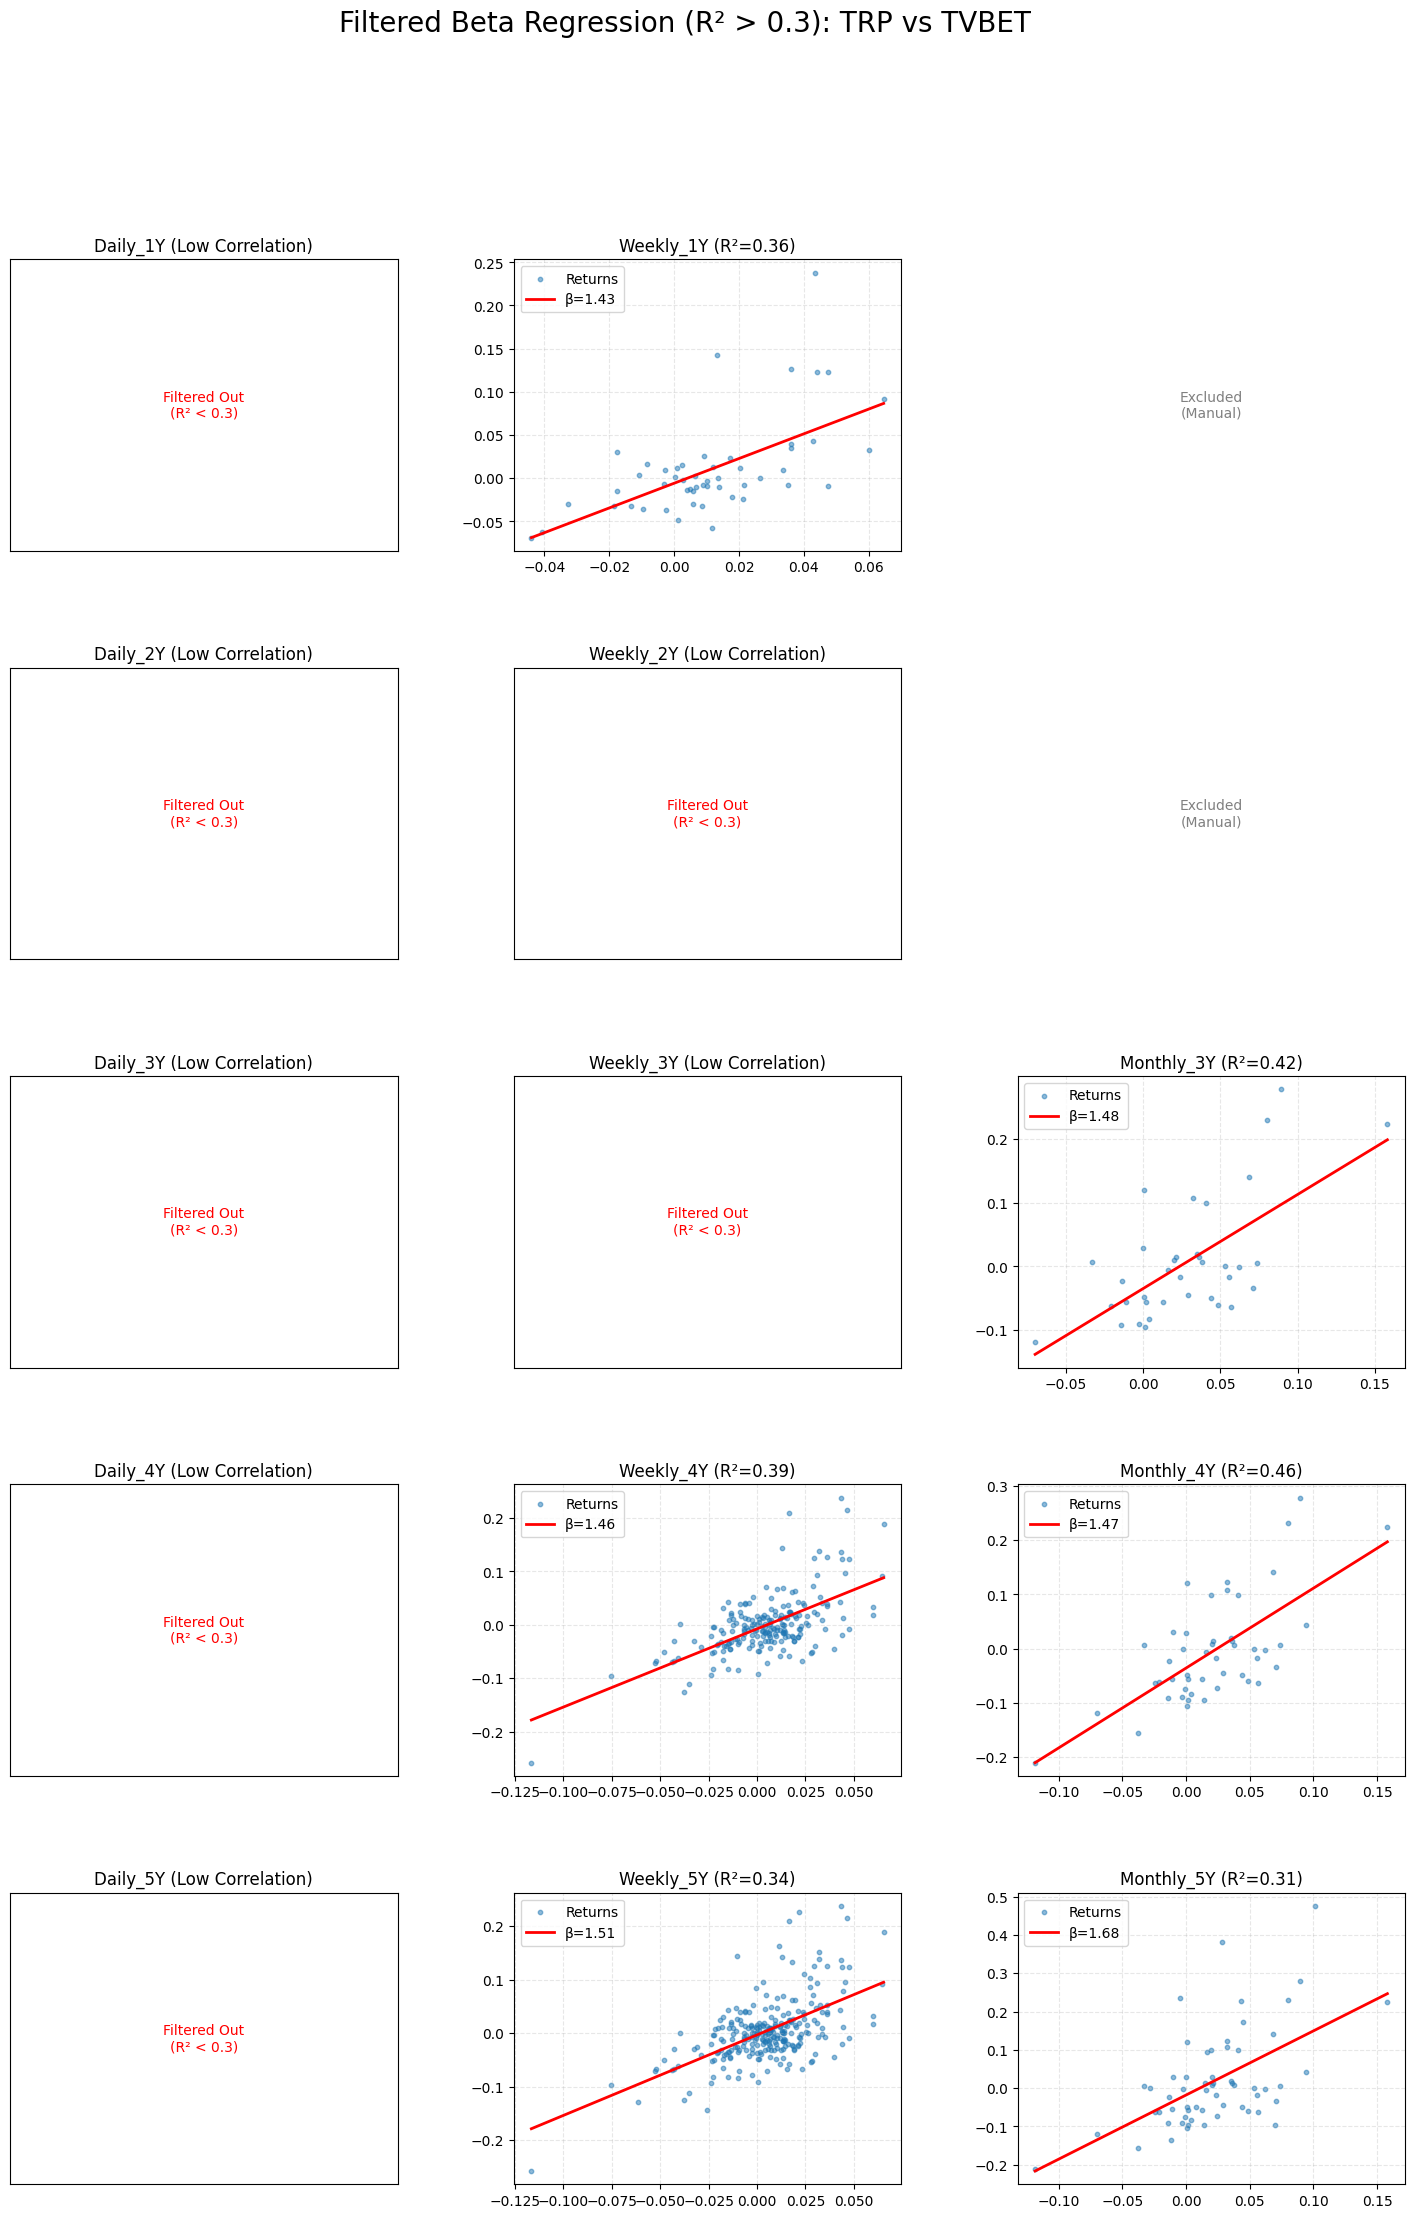

In [5]:
fig, axes = plt.subplots(5, 3, figsize=(18, 25))
fig.suptitle(f'Filtered Beta Regression (R² > {R2_THRESHOLD}): TRP vs TVBET', fontsize=20)
plt.subplots_adjust(hspace=0.4, wspace=0.3)
freq_col_map = {'Daily': 0, 'Weekly': 1, 'Monthly': 2}

for year in range(1, 6):
    for freq in ['Daily', 'Weekly', 'Monthly']:
        sheet_name = f"{freq}_{year}Y"
        row_idx = year - 1
        col_idx = freq_col_map.get(freq, 0)
        ax = axes[row_idx, col_idx]
        if sheet_name in EXCLUDED_SHEETS:
            ax.text(0.5, 0.5, 'Excluded\n(Manual)', ha='center', va='center', color='gray')
            ax.set_axis_off()
            continue
        data = plot_data.get(sheet_name)
        if data:
            x_vals = data['X']
            y_vals = data['Y']
            b = data['Beta']
            a = data['Alpha']
            r2 = data['R_Squared']
            ax.scatter(x_vals, y_vals, alpha=0.5, s=10, label='Returns')
            x_range = np.linspace(x_vals.min(), x_vals.max(), 100)
            y_pred = a + b * x_range
            ax.plot(x_range, y_pred, color='red', linewidth=2, label=f'β={b:.2f}')
            ax.set_title(f"{sheet_name} (R²={r2:.2f})")
            ax.legend(loc='upper left')
            ax.grid(True, linestyle='--', alpha=0.3)
        else:
            # Display why the plot is empty
            ax.text(0.5, 0.5, f'Filtered Out\n(R² < {R2_THRESHOLD})',
                    ha='center', va='center', fontsize=10, color='red', transform=ax.transAxes)
            ax.set_title(f"{sheet_name} (Low Correlation)")
            ax.set_xticks([]);
            ax.set_yticks([])

In [6]:
results_df = pd.DataFrame(results_list)

if not results_df.empty:
    median_beta = results_df['Beta'].median()
    cost_of_equity = RISK_FREE_RATE + median_beta * EQUITY_RISK_PREMIUM
    print("\n" + "=" * 60)
    print(f"FINAL STATS (ONLY MODELS WITH R² > {R2_THRESHOLD})")
    print("-" * 60)
    print(
        results_df[['Sheet', 'Beta', 'R_Squared']].sort_values(by='R_Squared', ascending=False).to_string(index=False))
    print("\n" + "=" * 60)
    print(f"Median Beta (Filtered):  {median_beta:.4f}")
    print(f"Risk-Free Rate:          {RISK_FREE_RATE:.2%}")
    print(f"Equity Risk Premium:     {EQUITY_RISK_PREMIUM:.2%}")
    print(f"CAPM COST OF EQUITY:     {cost_of_equity:.2%}")
    print("=" * 60)
else:
    print(f"\nNo data met the threshold of R² > {R2_THRESHOLD}.")

plt.show()


FINAL STATS (ONLY MODELS WITH R² > 0.3)
------------------------------------------------------------
     Sheet     Beta  R_Squared
Monthly_4Y 1.472527   0.460117
Monthly_3Y 1.480023   0.417145
 Weekly_4Y 1.463316   0.385180
 Weekly_1Y 1.431428   0.357742
 Weekly_5Y 1.506793   0.338062
Monthly_5Y 1.675159   0.313139

Median Beta (Filtered):  1.4763
Risk-Free Rate:          6.80%
Equity Risk Premium:     5.50%
CAPM COST OF EQUITY:     14.92%
